#Ejemplo práctico de pandas

En la siguiente ayudantía se utilizará la librería `pandas`, `json` y `matplotlib` para procesar datos y visualizarlos. Se hará el supuesto de que paseen un manejo básico con `pandas`. De no ser así, se recomienda estudiar dicha librería con la [siguiente ayudantía](https://github.com/nebil/data-wrangling) creada por [Nebil Kawas](https://github.com/nebil).

En caso de aplicar este código desde google colab, es necesario descargar la base de datos. Las siguientes 2 línes se encargar de bajar el archivo y descomprimirlo. Si ya tienes la base de datos descargada, no es necesario ejecutar estas dos líneas.

In [1]:
!wget https://www.dropbox.com/s/ixsf5aiu92l3z62/countriesFiles.zip
!unzip -o countriesFiles.zip

--2018-08-13 02:12:05--  https://www.dropbox.com/s/ixsf5aiu92l3z62/countriesFiles.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ixsf5aiu92l3z62/countriesFiles.zip [following]
--2018-08-13 02:12:06--  https://www.dropbox.com/s/raw/ixsf5aiu92l3z62/countriesFiles.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc39239c7171ac9610f14c8cd324.dl.dropboxusercontent.com/cd/0/inline/ANw0e98zVI1nxXwhUBntkeyoE2exDaSsai2ZVVumjYh_XDW4u4Q5YYzm88Kjz5AmbeIeE5xazEbmxP7dFhewg2ETl5lh72hJWcQPSj390ZEJDBqW0P7UhW_TrJvBB0STOBXh-wLBaYM2EfF7qZMU43ofeEq_WUQLY6doqPvl2qWU2KbK6SlF6B8nlCHLCB-nZzk/file [following]
--2018-08-13 02:12:06--  https://uc39239c7171ac9610f14c8cd324.dl.dropboxusercontent.com/cd/0/inline/ANw0e98zVI1nxXwhUBntkeyoE2exDaS

# Religión en el mundo

Disponemos de archivos que describen la evolución de la población segmentada por sus afiliaciones religiosas. En específico, muestran la cantidad de personas que se registran asociadas a distintas religiones a través de los años y en diferentes paises. El objetivo de este ejemplo es  identificar **la religión más popular en número de paises y cómo ha evolucionado a nivel mundial la cantidad de personas adherida al Cristianismo, Budismo e Islam a través de los años**. Responder estas preguntas directamente es imposible, ya que los datos vienen a nivel granular y es necesario realizar algún manejo sobre ellos. Los datos están en diferentes archivos, diferentes formatos y hay paises con información errada que es necesario filtrar.

## ¿Qué queremos?
- Histograma de número de paises afiliados a religiones, como mayoría
- Gráfico de línea de la población mundial adherida al Cristianismo, Budismo o Islam a través de los años

## ¿Qué tenemos?
### _Countries1.csv_
Archivo CSV con la población por religión de algunos paises. Cada fila indica la cantidad de personas inscritas en alguna religión especifica según el pais y año. Las columnas son:
-  _year_: año de la información obtenida.
- _country_: código del pais de donde se obtuvo la información.
- _religionCode_: código único que representa una religión.
- _population_: cantidad de personas inscritas en dicha religión.
- _submitDate_: fecha de cuando se obtuvo dicha información.

Un ejemplo del archivo en cuestión es:
```
year,country,religionCode,population,submitDate
1945,CLP,islmgen,1000000,1946-09-03
1955,PER,budgen,840000,1956-02-03
```

### _Countries2.json_
Archivo JSON el cual contiene a un diccionario donde cada _key_ es un código del pais y su _value_ es una lista con otros diccionarios cuyas propiedades son:
-  `year`: año de la información obtenida.
- `religionCode`: código único que representa una religión.
- `population`: cantidad de personas inscritas en dicha religión.

Un ejemplo del archivo es:
```
{
  "ESP":
    [
      {
        "year": 1950,
        "religionCode": "taogen",
        "population": 11918122
      },
      {
        "year": 2000,
        "religionCode": "taogen",
        "population": 13123123
      },
    ],
    ...
}
```
  
  
### _CodeCountries.csv_
Archivo CSV con la traduccion de los códigos de los paises. Posee dos columnas:
- code: indica el código del país.
- country: indica el nombre asociado a dicho código.

Un ejemplo del archivo es:
```
code,country
CLP,Chile
PER,Peru
```

### _BadCountries.txt_
Archivo de texto con una lista de los nombres de países que poseen información errada. Un ejemplo del archivo es:
```
Argentina
Holanda
```

## ¿Problemas?
- Los información de países provienen de dos archivos diferentes.
- Cada archivo tiene un formato diferente.
- Existe una lista de países que tienen problemas en los _datasets_ que son necesarios filtrar.
- La información de paises están asociadas a siglas, mientras que la lista de paises a filtrar aparecen con nombre.


## ¿Qué haremos?

Usaremos Pandas para:
- Unificar varios _datasets_.
- Filtrar el _dataset_ unificado.
- Agregar columna calculada en base a otras columnas.
- Alterar estructura del _dataset_.
- Agrupar según ciertos atributos.
- Visualizar lo solicitado.

## Importación de librerías
Primero es necesario importar todas las librerías necesarias, en este caso será [``json``](https://docs.python.org/2/library/json.html) para abrir el archivo _Countries.json_, [``pandas``](https://pandas.pydata.org/) para poder procesar toda la información y [``matplotlib``](https://matplotlib.org/) para visualizar.

In [0]:
import pandas as pd
import json
import matplotlib.pyplot as plt

# Unificar archivos

Para _Countries1.csv_ vamos a usar la función [`read_csv`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) de `pandas`. Notar que hay una columna que no necesitamos (`submitDate`). Por lo tanto usaremos el argumento `usecols` para especificar a `pandas` que columnas cargar del csv. 

Para _Countries2.json_, usaremos la función load de `json` y luego vamos a generar una lista de listas donde cada lista representará una fila con el mismo formato que el CSV, es decir:
```
year,country,religionCode,population
```
Finalmente convertiremos dicha lista de listas a un [`DataFrame`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) de `pandas` para utilizar el método [`concat`](https://pandas.pydata.org/pandas-docs/stable/merging.html) de `pandas` y unificar ambos archivos en solo un `DataFrame`.

In [3]:
countries_1 = pd.read_csv("Countries1.csv", sep=",", usecols=["year", "country", "religionCode", "population"])

json_data = []
with open("Countries2.json") as file:
    dict_country = json.load(file)

for country in dict_country.keys():
    for data in dict_country[country]:
        json_data.append([data["year"], country, data["religionCode"], data["population"]])

countries_2 = pd.DataFrame(json_data, columns=["year", "country", "religionCode", "population"])

countries = pd.concat([countries_1, countries_2])
countries.head()

,year,country,religionCode,population
0,1945,USA,chrstgen,110265118
1,1945,USA,judgen,4641182
2,1945,USA,islmgen,0
3,1945,USA,budgen,1601218
4,1945,USA,zorogen,0


# Modificar `countries`
Ahora, vamos a reemplazar cada sigla de país por su nombre adecuado para posteriormente poder filtrar los paises indicados en _BadCountries.txt_.

En esta parte se puede realizar de dos formas:
1. Reemplazar cada sigla por el nombre mediante el uso de un diccionario.
1. Realizar _join_ entre las 2 tablas donde la _key_ para hacer el join sea el código.

En esta ocasión usaremos el primero método para hacer uso de `to_dict` y `map`.

Primero, es necesario abrir _CodeCountries.csv_ y lo transformaremos en un diccionario donde la _key_ será la sigla y la _value_ será el nombre del país. Para esto es necesario utilizar el método `to_dict`, el cual lo aplicaremos a una [`Series`](https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.Series.html) de `pandas` y por defecto toma el índice de cada elemento como la _key_ y el elemento será la _value_. Por lo tanto, partimos cargando el CSV e indicamos cual será el índice de cada elemento, para esto ocupamos el método [`read_csv`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) y el parametro `index_col` para indicar su índice. Luego, seleccionamos la columna que será la value (``["country"]``) y aplicamos el método [`to_dict`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.to_dict.html).


In [0]:
country_code = pd.read_csv("CodeCountries.csv", sep=",", index_col = "code")
country_code = country_code["country"].to_dict()


Ya disponemos del diccionario, ahora creamos la función que dado el código de un pais, retorne el nombre de dicho país. Finalmente utilizamos el método [`map`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) de `pandas` para aplicar dicha función a una columna.

**Importante**: El método `to_dict` tambien puede ser aplicado a un [`DataFrame`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_dict.html)

In [5]:
def change_name(code):
    return country_code[code]

countries.country = countries.country.map(change_name)
countries.head()

,year,country,religionCode,population
0,1945,United States of America,chrstgen,110265118
1,1945,United States of America,judgen,4641182
2,1945,United States of America,islmgen,0
3,1945,United States of America,budgen,1601218
4,1945,United States of America,zorogen,0


En caso de querer realizar _join_. En necesario utilizar el método [`set_index`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.set_index.html) para que ambas tablas tengan el mismo índice y luego aplicar [`join`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) para unirlos. El código sería así:
```
countries.set_index("country").join(country_code).reset_index().drop(["index"], axis=1)
```

El ``reset_index`` y ``drop`` son para dejar los índices en forma numérica y eliminar la columna _"index"_.

# Filtrar información errada
Como los paises ya tienen su nombre, podemos filtrar aquellos que están incluidos en la lista de _BadCountries.txt_. Para esto utilizaremos el método [`isin`](https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.Series.isin.html) para verificar si el país en cuestión está incluido en una lista.

Vamos a imprimir las dimensiones del dataframe antes y despues de filtrar para verificar que se eliminaron ciertas filas.

In [6]:
print(countries.shape)
with open("BadCountries.txt") as file:
    bad_country = [x.strip("\n") for x in file]
countries = countries[~countries.country.isin(bad_country)]
print(countries.shape)

(19950, 4)
(18550, 4)


# Alterar estructura del _dataset_

Actualmente, cada fila representa la población de una religión especifica para un país en algún año, lo cual implica muchos datos repetidos, porque para cada religiones, estamos repitiendo el año y nombre de dicho país. Por lo tanto, vamos a cambiar el formato en donde pondremos cada religión como una columna junto con el país y el año, de esta forma, cada fila representa **toda la información de ese país para un año especifico**.

Para lograr este objetivo vamos a generar un nuevo _dataset_ con el siguiente formato:

```
country,year,religion_1,religion_2,...,religion_n
```
Primero vamos a utilizar el método [`groupby`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html) para generar grupos de filas en donde agruparemos por país y año, así obtenedremos como grupo todas la población de cada religión asociada a un país y año en especifico.

**Nota adicional**: Más información de `groupby` [aquí](https://pandas.pydata.org/pandas-docs/stable/groupby.html)

Luego, para cada grupo, vamos a tomar la columna de la religión y población, setearemos como índice la columna de religión (_religionCode_) y finalmente vamos a [transponer](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.transpose.html) dicho `DataFrame`. 

## ¿Por qué setear el indice?
Cuando uno transpone un `DataFrame`, el índice de cada fila pasa a ser el _header_ del `DataFrame` y el _header_ anterior pasa a ser el índice de dicha fila. Si no seteabamos el índice como una de las columnas, se iban a utilizar los índices numéricos que vienen por defecto.

En base a lo anterior, la línea 6 del código se encarga de cambiar el nombre del nuevo _header_ para que no se llame _religionCode_.

Finalmente utilizamos `concat` para concatenar cada fila generada por grupo. Utilizaremos el argumento `ignore_index=True` para que el indice de cada fila sea la versión numérica.





In [7]:
new_dataframe = []
group_data = countries.groupby(['country', 'year'])
for country_year_group in group_data.groups:
    group = group_data.get_group(country_year_group)
    new_row = group[["religionCode", "population"]].set_index("religionCode").T
    new_row.columns.name = "Columns" 


    new_row["country"] = country_year_group[0]
    new_row["year"] = country_year_group[1]
    new_dataframe.append(new_row)
    
final_dataset = pd.concat(new_dataframe, ignore_index=True)
final_dataset.head()

Columns,chrstgen,judgen,islmgen,budgen,zorogen,hindgen,sikhgen,shntgen,taogen,jaingen,country,year
0,210,642,8391998,1926,2592,3304,2175,0,0,0,Afghanistan,1945
1,550,549,8910175,2195,2750,8018,2195,0,0,0,Afghanistan,1950
2,2418,469,9658503,2501,2917,16736,2215,0,0,0,Afghanistan,1955
3,4285,389,10537389,2807,3085,62453,2235,0,0,0,Afghanistan,1960
4,6153,308,11825320,3113,3252,88171,2255,0,0,0,Afghanistan,1965


# Traducir columnas

Como extra, los ayudantes buscaron el nombre de cada religión según el código utilizado. De este modo podemos cambiar el nombre de las columnas a uno legible. Para esto ocuparemos nuevamente una función que dado un código retorne el valor del diccionario y usaremos el método `map` para aplicar dicha función a cada elemento.

In [8]:
translate = {
    "chrstgen": "Christianity", "judgen"  : "Judaism"        , "islmgen" : "Islam",
    "budgen"  : "Buddhism"    , "zorogen" : "Zoroastrianism" , "hindgen" : "Hinduism",
    "sikhgen" : "Sikhism"     , "shntgen" : "Shintoism"      ,
    "taogen"  : "Taoism"      , "jaingen" : "Confucianism"
}

def change_columns(column):
    return translate[column] if column in translate else column
    
final_dataset.columns = final_dataset.columns.map(change_columns)

final_dataset.head()

Columns,Christianity,Judaism,Islam,Buddhism,Zoroastrianism,Hinduism,Sikhism,Shintoism,Taoism,Confucianism,country,year
0,210,642,8391998,1926,2592,3304,2175,0,0,0,Afghanistan,1945
1,550,549,8910175,2195,2750,8018,2195,0,0,0,Afghanistan,1950
2,2418,469,9658503,2501,2917,16736,2215,0,0,0,Afghanistan,1955
3,4285,389,10537389,2807,3085,62453,2235,0,0,0,Afghanistan,1960
4,6153,308,11825320,3113,3252,88171,2255,0,0,0,Afghanistan,1965


# Agregar columna con religión popular
Terminado el preprocesamiento, es necesario empezar a generar la información que queremos para visualizar.

Para la primera visualización, necesitamos la religión popular por país, es decir, aquella religión que tenga mayor población adherida a ella. Para esto, filtraremos para solo tener la información del último año, en este caso, 2010. Luego aplicaremos el método [`idxmax`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.idxmax.html) con `axis=1`. Esto retornará, para cada fila, aquella columna que tenga el dato más alto. Adicionalmente aplicaremos un selector de columnas con `list(translate.values())`. De este modo solo buscará entre las columnas de religiones, excluyendo _year_ y _country_ en esta busqueda.

In [15]:
visualization_1 = final_dataset[final_dataset["year"] == 2010].copy()
popular_religion = visualization_1[list(translate.values())].idxmax(axis=1) 
visualization_1["popular_religion"] = popular_religion

visualization_1.head()

Columns,Christianity,Judaism,Islam,Buddhism,Zoroastrianism,Hinduism,Sikhism,Shintoism,Taoism,Confucianism,country,year,popular_religion
13,7287,0,26880000,2500,2000,8000,2000,0,0,0,Afghanistan,2010,Islam
27,685221,0,2013180,0,0,0,0,0,0,0,Albania,2010,Islam
37,285330,0,35309660,0,0,0,0,0,0,0,Algeria,2010,Islam
45,17034849,0,198750,1634,0,0,0,0,0,0,Angola,2010,Christianity
52,79425,0,0,0,0,0,0,0,0,0,Antigua & Barbuda,2010,Christianity


# Agrupar y agregar la población por año

Para la segunda visualización, necesitamos la población total por año y religión, sin importar el país. Para esto utilizamos el método `groupby` y `sum` para agrugar las filas por año y sumar los datos de cada grupo, con ello obtendremos la cantidad de personas de una religión en cada año sin importar el país. Como estamos aplicando suma a los grupos, `pandas` por defecto eliminará las columanas que no pueda aplicar dicha operación, en este caso elimina _country_.

In [13]:
visualization_2 = final_dataset.groupby('year').sum()
visualization_2.head()

Columns,Christianity,Judaism,Islam,Buddhism,Zoroastrianism,Hinduism,Sikhism,Shintoism,Taoism,Confucianism
year,,,,,,,,,,
1945,697451128,12004695,130689131,115173436,12710,208065,20809,55228775,120950,181
1950,691825889,13694537,293418699,152969545,118533,294064662,5919504,65452839,921828,1817254
1955,831061339,12982377,343275746,172631683,139618,320820625,6391600,68145114,1182738,1620067
1960,961744265,13724815,431939629,192992379,169083,352534527,8069158,71357167,1357348,2030570
1965,1069278105,14250064,510639609,203990394,147369,388504037,8873741,74982591,1704647,2339964


# Visualizar ambos dataset

Ya disponemos de la información lista para visulizar, ahora tomamos la columna _popular_\__religion_ y le aplicamos el método [`hist`](https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.Series.hist.html) para generar un histograma. Adicionalmente le agregamos título y nombre a los ejes.

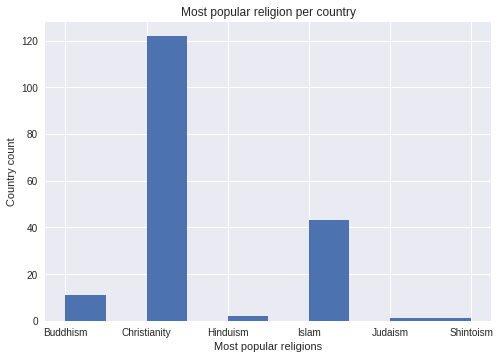

In [14]:
title = "Most popular religion per country"
y_label = "Country count"
x_label = "Most popular religions"

plot = visualization_1.popular_religion.hist()
plot.set_xlabel(x_label)
plot.set_ylabel(y_label)
plot.set_title(title)
plt.show()


Para el gráfico de línea, primero es necesario seleccionar las columnas y luego aplicar el método [`plot`](https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.DataFrame.plot.html) para crear dicho gráfico con 3 líneas distintas (1 por columna).

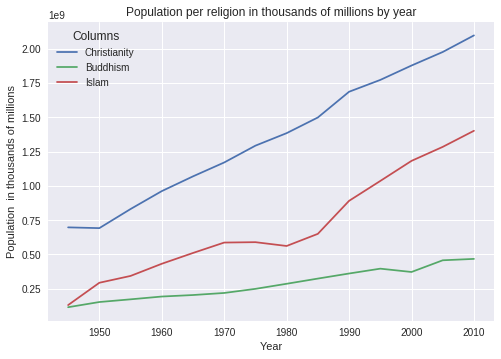

In [12]:
title = "Population per religion in thousands of millions by year"
x_label = "Year"
y_label = "Population  in thousands of millions"
plot = visualization_2[["Christianity", "Buddhism", "Islam"]].plot(title=title)
plot.set_xlabel(x_label)
plot.set_ylabel(y_label)
plt.show()